# ロジスティック回帰とパーセプトロンの比較

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame
from numpy.random import rand, multivariate_normal
pd.options.mode.chained_assignment = None
numpy.random.seed(10)

## Parameters

In [2]:
Variances = [5,10,30,50] # 両クラス共通の分散（4種類の分散で計算を実施）

## データセット {x_n,y_n,type_n} を用意

In [3]:
def prepare_dataset(variance):
    n1 = 10
    n2 = 10
    mu1 = [7,7]
    mu2 = [-3,-3]
    cov1 = np.array([[variance,0],[0,variance]])
    cov2 = np.array([[variance,0],[0,variance]])

    df1 = DataFrame(multivariate_normal(mu1,cov1,n1),columns=['x','y'])
    df1['type'] = 1
    df2 = DataFrame(multivariate_normal(mu2,cov2,n2),columns=['x','y'])
    df2['type'] = 0
    df = pd.concat([df1,df2],ignore_index=True)
    df = df.reindex(np.random.permutation(df.index)).reset_index(drop=True)
    return(df)

## ロジスティック回帰

In [4]:
def run_logistic(train_set, subplot):
    w = np.array([[0],[0.1],[0.1]])
    phi = train_set[['x','y']]
    phi['bias'] = 1
    phi = phi.as_matrix(columns=['bias','x','y'])
    t = train_set[['type']]
    t = t.as_matrix()
    # 最大30回のIterationを実施
    for i in range(30):
        # IRLS法によるパラメータの修正
        y = np.array([])
        for line in phi:
            a = np.dot(line, w)
            y = np.append(y, [1.0/(1.0+np.exp(-a))])
        r = np.diag(y*(1-y)) 
        y = y[np.newaxis,:].T
        tmp1 = np.linalg.inv(np.dot(np.dot(phi.T, r),phi))
        tmp2 = np.dot(phi.T, (y-t))
        w_new = w - np.dot(tmp1, tmp2)
        # パラメータの変化が 0.1% 未満になったら終了
        if np.dot((w_new-w).T, (w_new-w)) < 0.001 * np.dot(w.T, w):
            w = w_new
            break
        w = w_new
    # 分類誤差の計算
    w0, w1, w2 = w[0], w[1], w[2]
    err = 0
    for index, point in train_set.iterrows():
        x, y, type = point.x, point.y, point.type
        type = type * 2 - 1
        if type * (w0 + w1*x + w2*y) < 0:
            err += 1
    err_rate = err * 100 / len(train_set)
    # 結果を表示
    xmin, xmax = train_set.x.min()-5, train_set.x.max()+10
    linex = np.arange(xmin-5, xmax+5)
    liney = - linex * w1 / w2 - w0 / w2
    label = "ERR %.2f%%" % err_rate
    subplot.plot(linex,liney ,label=label, color='blue')
    #subplot.legend(loc=1)
    subplot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

## パーセプトロン

In [5]:
def run_perceptron(train_set, subplot):
    w0 = w1 = w2 = 0.0
    bias = 0.5 * (train_set.x.mean() + train_set.y.mean())

    # Iterationを30回実施
    for i in range(30):
        # 確率的勾配降下法によるパラメータの修正
        for index, point in train_set.iterrows():
            x, y, type = point.x, point.y, point.type
            type = type*2-1
            if type * (w0*bias + w1*x + w2*y) <= 0:
                w0 += type * 1
                w1 += type * x
                w2 += type * y
    # 分類誤差の計算
    err = 0
    for index, point in train_set.iterrows():
        x, y, type = point.x, point.y, point.type
        type = type*2-1
        if type * (w0*bias + w1*x + w2*y) <= 0:
            err += 1
    err_rate = err * 100 / len(train_set)

    # 結果を表示
    xmin, xmax = train_set.x.min()-5, train_set.x.max()+10
    linex = np.arange(xmin-5, xmax+5)
    liney = - linex * w1 / w2 - bias * w0 / w2
    label = "ERR %.2f%%" % err_rate
    subplot.plot(linex, liney, label=label, color='red', linestyle='--')
    #subplot.legend(loc=1)
    subplot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

## データを準備してロジスティック回帰とパーセプトロンを実行

In [6]:
def run_simulation(variance, subplot):
    train_set = prepare_dataset(variance)
    train_set1 = train_set[train_set['type']==1]
    train_set2 = train_set[train_set['type']==0]
    ymin, ymax = train_set.y.min()-5, train_set.y.max()+10
    xmin, xmax = train_set.x.min()-5, train_set.x.max()+10
    subplot.set_ylim([ymin-1, ymax+1])
    subplot.set_xlim([xmin-1, xmax+1])
    subplot.scatter(train_set1.x, train_set1.y, marker='o')
    subplot.scatter(train_set2.x, train_set2.y, marker='x')
    run_logistic(train_set, subplot)
    run_perceptron(train_set, subplot)

## Main

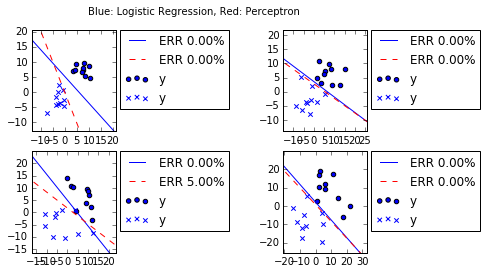

In [7]:
fig = plt.figure()
plt.suptitle('Blue: Logistic Regression, Red: Perceptron')
for c, variance in enumerate(Variances):
    subplot = fig.add_subplot(2, 2, c + 1)
    fig.subplots_adjust(wspace = 2)
    run_simulation(variance, subplot)
fig